In [1]:
import copy
import json
import os
import time
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader

from Common import NeuralNet, EarlyStopping, TrainingConfig

In [2]:
class HeatIPINN:
    def __init__(self, n_int, n_sb, n_tb, n_meas, lambda_u=10, n_hidden_layers=4, neurons=20, lambda_m=10, n_hidden_layers_cf=4, neurons_cf=20, retrain_seed=42, device='cuda' if torch.cuda.is_available() else 'cpu'):

        self.device = device
        self.dtype = torch.float32


        self.n_int = n_int
        self.n_sb = n_sb
        self.n_tb = n_tb
        self.n_meas = n_meas

        # Extrema of the solution domain (t,x)
        time_domain, space_domain = [0, 0.1], [-1, 1]
        self.domain_extrema = torch.tensor([time_domain, space_domain])

        # Parameter to balance the role of data and PDE
        self.lambda_u = lambda_u

        # Parameter to balance the role of measurement data and PDE
        self.lambda_m = lambda_m

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])
        # F Dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1, n_hidden_layers=n_hidden_layers, neurons=neurons, retrain_seed=retrain_seed, device=device).to(device)

        self.approximate_coefficient = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1, n_hidden_layers=n_hidden_layers_cf, neurons=neurons_cf, retrain_seed=retrain_seed, device=device).to(device)

        self.ms = lambda x: torch.mean(torch.square(x))
        # Create directory to save plots
        path = os.path.join('/Users/omar/Desktop/Thesis/plots', self.__class__.__name__, datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
        os.makedirs(path)
        self.path = path

    # Function to linearly transform a tensor whose value is between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    def save_config(self, optimizer):
        class_config = {
            'n_int': self.n_int,
            'n_sb': self.n_sb,
            'n_tb': self.n_tb,
            'n_meas': self.n_meas,
            'lambda_u': self.lambda_u,
            'lambda_m': self.lambda_m,
            'n_hidden_layers': self.approximate_solution.n_hidden_layers,
            'neurons': self.approximate_solution.neurons,
            'n_hidden_layers_cf': self.approximate_coefficient.n_hidden_layers,
            'neurons_cf': self.approximate_coefficient.neurons,
            'retrain_seed': self.approximate_solution.retrain_seed,
            'device': self.device,
            'optimizer_config': optimizer.defaults
        }
        # Save configuration in json file
        with open(f'{self.path}/config.json', 'w') as f:
            json.dump(class_config, f)

    def exact_solution(self, inputs):
        t = inputs[:, 0]
        x = inputs[:, 1]
        u = -torch.exp(-np.pi ** 2 * t) * torch.sin(np.pi * x)
        return u

    def initial_condition(self, x):
        return -torch.sin(np.pi * x)

    def right_boundary_condition(self, t):
        return torch.zeros(t.shape[0], 1)

    def left_boundary_condition(self, t):
        return torch.zeros(t.shape[0], 1)

    def exact_coefficient(self, inputs):
        x = inputs[:, 1]
        k = (torch.sin(np.pi * x) + 1.1)

        return k

    def source(self, inputs):
        s = -np.pi**2*self.exact_solution(inputs)*(1 - self.exact_coefficient(inputs))
        return s

    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int).reshape(-1,)
        k = self.approximate_coefficient(input_int).reshape(-1,)
        grad_u = torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        grad_u_t = grad_u[:, 0]
        grad_u_x = grad_u[:, 1]
        grad_u_xx = torch.autograd.grad(grad_u_x.sum(), input_int, create_graph=True)[0][:, 1]
        s = self.source(input_int)
        residual = grad_u_t - k*grad_u_xx - s
        return residual.reshape(-1, )

    ###############################################################################################
    # add points
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb = input_tb.to(self.dtype).to(self.device)
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = self.initial_condition(input_tb[:, 1]).reshape(-1, 1)
        output_tb = output_tb.to(self.dtype).to(self.device)
        return input_tb, output_tb

    def add_spatial_boundary_points_left(self):
        x_left = self.domain_extrema[1, 0]
        input_sb = self.convert(self.soboleng.draw(self.n_sb))
        input_sb = input_sb.to(self.dtype).to(self.device)
        input_sb_left = torch.clone(input_sb)
        input_sb_left[:, 1] = torch.full(input_sb_left[:, 1].shape, x_left)

        output_sb_left = self.left_boundary_condition(input_sb_left[:, 0]).reshape(-1, 1)
        output_sb_left = output_sb_left.to(self.dtype).to(self.device)
        return input_sb_left, output_sb_left

    def add_spatial_boundary_points_right(self):
        x_right = self.domain_extrema[1, 1]
        input_sb = self.convert(self.soboleng.draw(self.n_sb))
        input_sb = input_sb.to(self.dtype).to(self.device)
        input_sb_right = torch.clone(input_sb)

        input_sb_right[:, 1] = torch.full(input_sb_right[:, 1].shape, x_right)

        output_sb_right = self.right_boundary_condition(input_sb_right[:, 0]).reshape(-1, 1)
        output_sb_right = output_sb_right.to(self.dtype).to(self.device)
        return input_sb_right, output_sb_right


    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        input_int = input_int.to(self.dtype).to(self.device)
        output_int = torch.zeros((input_int.shape[0], 1))
        output_int = output_int.to(self.dtype).to(self.device)
        return input_int, output_int


    def get_measurement_data(self):
        torch.random.manual_seed(42)
        t = torch.linspace(self.domain_extrema[0, 0], self.domain_extrema[0, 1], self.n_meas)
        x = torch.linspace(self.domain_extrema[1, 0], self.domain_extrema[1, 1], self.n_meas)
        input_meas = torch.cartesian_prod(t, x)
        input_meas = input_meas.to(self.dtype).to(self.device)
        output_meas = self.exact_solution(input_meas).reshape(-1,1)
        output_meas = output_meas.to(self.dtype).to(self.device)
        return input_meas, output_meas

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb_left, output_sb_left = self.add_spatial_boundary_points_left()
        input_sb_right, output_sb_right = self.add_spatial_boundary_points_right()
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int
        training_set_sb_left = DataLoader(torch.utils.data.TensorDataset(input_sb_left, output_sb_left), batch_size=self.n_sb, shuffle=False)
        training_set_sb_right = DataLoader(torch.utils.data.TensorDataset(input_sb_right, output_sb_right), batch_size=self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)
        return training_set_sb_left, training_set_sb_right, training_set_tb, training_set_int

    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        u_pred_tb = u_pred_tb.to(self.dtype).to(self.device)
        return u_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions_left(self, input_sb):
        u_pred_sb = self.approximate_solution(input_sb)
        u_pred_sb = u_pred_sb.to(self.dtype).to(self.device)
        return u_pred_sb

    def apply_boundary_conditions_right(self, input_sb):
        u_pred_sb = self.approximate_solution(input_sb)
        u_pred_sb = u_pred_sb.to(self.dtype).to(self.device)
        return u_pred_sb

    ################################################################################################
    def optimizer_LBFGS(self, config):
        """Create LBFGS optimizer with specified configuration."""
        return torch.optim.LBFGS(
            list(self.approximate_solution.parameters())+list(self.approximate_coefficient.parameters()),
            lr=float(config.lr),
            max_iter=config.max_iter,
            max_eval=config.max_eval,
            history_size=config.history_size,
            line_search_fn=config.line_search_fn,
            tolerance_change=1.0 * np.finfo(float).eps
        )

    def optimizer_ADAM(self, lr=1e-5):
        return torch.optim.Adam(list(self.approximate_solution.parameters())+list(self.approximate_coefficient.parameters()), lr=float(lr))

# Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, train_points):
        (inp_train_sb_left, u_train_sb_left, inp_train_sb_right, u_train_sb_right,
         inp_train_tb, u_train_tb, inp_train_int) = train_points
        inp_train_meas, u_train_meas = self.get_measurement_data()
        u_pred_meas = self.approximate_solution(inp_train_meas)

        # Compute boundary predictions
        u_pred_sb_left = self.apply_boundary_conditions_left(inp_train_sb_left)
        u_pred_sb_right = self.apply_boundary_conditions_right(inp_train_sb_right)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)

        # Validate shapes
        assert (u_pred_sb_left.shape[1] == u_train_sb_left.shape[1])
        assert (u_pred_sb_right.shape[1] == u_train_sb_right.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])

        # Compute residuals
        r_int = self.compute_pde_residual(inp_train_int)
        r_sb_left = u_train_sb_left - u_pred_sb_left
        r_sb_right = u_train_sb_right - u_pred_sb_right
        r_tb = u_train_tb - u_pred_tb
        r_meas = u_train_meas - u_pred_meas

        # Compute individual losses
        loss_sb_left = self.ms(r_sb_left)
        loss_sb_right = self.ms(r_sb_right)
        loss_tb = self.ms(r_tb)
        loss_int = self.ms(r_int)
        loss_meas = self.ms(r_meas)

        # Compute boundary loss
        loss_u = loss_sb_left + loss_tb + loss_sb_right + loss_meas

        # Total loss with log scaling
        loss = torch.log10(self.lambda_u * loss_u + loss_int)

        return loss, loss_u, loss_int, loss_meas

    def enhanced_fit(self, num_epochs, optimizer, config=None, verbose=True):
        if config is None:
            config = TrainingConfig(num_epochs=num_epochs)

        self.save_config(optimizer)
        history = {
            'total_loss': [],
            'pde_loss': [],
            'boundary_loss': [],
            'coefficient_loss': [],
            'learning_rate': []
        }

        # Initialize early stopping
        early_stopping = EarlyStopping(
            patience=config.early_stopping_patience,
            min_delta=config.early_stopping_min_delta
        )

        # Setup scheduler for ADAM
        is_lbfgs = isinstance(optimizer, torch.optim.LBFGS)
        scheduler = None
        if not is_lbfgs:
            scheduler = ReduceLROnPlateau(
                optimizer,
                mode='min',
                factor=config.scheduler_factor,
                patience=config.scheduler_patience,
                min_lr=config.scheduler_min_lr,
                verbose=verbose
            )

        # Get training datasets
        training_sets = self.assemble_datasets()
        training_set_sb_left, training_set_sb_right, training_set_tb, training_set_int = training_sets

        for epoch in range(num_epochs):
            epoch_losses = []

            if verbose and epoch % max(1, num_epochs // 10) == 0:
                print(f"\nEpoch [{epoch + 1}/{num_epochs}]")

            for data in zip(training_set_sb_left, training_set_sb_right, training_set_tb, training_set_int):
                inp_train_sb_left, u_train_sb_left = data[0]
                inp_train_sb_right, u_train_sb_right = data[1]
                inp_train_tb, u_train_tb = data[2]
                inp_train_int, _ = data[3]

                def closure():
                    if is_lbfgs:
                        optimizer.zero_grad()

                    train_points = (inp_train_sb_left, u_train_sb_left, inp_train_sb_right, u_train_sb_right, inp_train_tb, u_train_tb, inp_train_int)

                    loss, loss_u, loss_int, loss_meas = self.compute_loss(train_points)
                    loss.backward()

                    epoch_losses.append({
                        'total': loss.item(),
                        'pde': torch.log10(loss_int).item(),
                        'boundary': torch.log10(loss_u).item(),
                        'coefficient': torch.log10(loss_meas).item()
                    })

                    return loss

                if is_lbfgs:
                    optimizer.step(closure)
                else:
                    optimizer.zero_grad()
                    loss = closure()
                    optimizer.step()

            # Calculate average losses
            avg_losses = {
                k: np.mean([loss[k] for loss in epoch_losses])
                for k in ['total', 'pde', 'boundary', 'coefficient']
            }

            # Update history
            history['total_loss'].append(avg_losses['total'])
            history['pde_loss'].append(avg_losses['pde'])
            history['boundary_loss'].append(avg_losses['boundary'])
            history['coefficient_loss'].append(avg_losses['coefficient'])
            history['learning_rate'].append(optimizer.param_groups[0]['lr'])

            # Update scheduler
            if scheduler is not None:
                scheduler.step(avg_losses['total'])

            # Print progress
            if verbose and epoch % max(1, num_epochs // 10) == 0:
                print(f"Total Loss: {avg_losses['total']:.6f} | "
                      f"Boundary Loss: {avg_losses['boundary']:.6f} | "
                      f"PDE Loss: {avg_losses['pde']:.6f} | "
                      f"Coefficient Loss: {avg_losses['coefficient']:.6f} | "
                      f"LR: {optimizer.param_groups[0]['lr']:.6e}")

            # Early stopping
            if early_stopping(self.approximate_solution, avg_losses['total']):
                if verbose:
                    print(f"\nEarly stopping triggered at epoch {epoch + 1}")
                early_stopping.restore_best_weights(self.approximate_solution)
                break

        if verbose:
            print(f"\nTraining completed. Final loss: {history['total_loss'][-1]:.6f}")

        return history
    ################################################################################################
    def get_pde_points(self, n_points):
        inputs = self.soboleng.draw(n_points)
        inputs = self.convert(inputs)
        output = self.approximate_solution(inputs).reshape(-1, )
        exact_output = self.exact_solution(inputs).reshape(-1, )
        return inputs, output, exact_output

    def get_coefficient_points(self, n_points):
        inputs = self.soboleng.draw(n_points)
        inputs = self.convert(inputs)
        output = self.approximate_coefficient(inputs).reshape(-1, )
        exact_output = self.exact_coefficient(inputs).reshape(-1, )
        return inputs, output, exact_output

    def relative_L2_error(self, n_points=10000, function='pde'):
        if function == 'pde':
            inputs, output, exact_output = self.get_pde_points(n_points)
        else:
            inputs, output, exact_output = self.get_coefficient_points(n_points)
        err = (torch.mean((output - exact_output) ** 2) / torch.mean(exact_output ** 2)) ** 0.5
        print(f'{function} loss:')
        print('L2 Relative Error Norm: {:.6e}'.format(err.item()))
        with open(f'{self.path}/relative_error.txt', 'a') as f:
            f.write(f'{function} loss:\n')
            f.write('L2 Relative Error Norm: {:.6e}\n'.format(err.item()))
        return inputs, output, exact_output

    def plotting_solution(self, n_points=50000, function='pde'):
        inputs, output, exact_output = self.relative_L2_error(n_points, function)
        inputs = inputs.cpu()
        output = output.cpu()
        exact_output = exact_output.cpu()
        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=exact_output.detach(), cmap='jet')
        axs[0].set_xlabel('x')
        axs[0].set_ylabel('t')
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which='both', ls=':')
        im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output.detach(), cmap='jet')
        axs[1].set_xlabel('x')
        axs[1].set_ylabel('t')
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which='both', ls=':')
        title = 'Solution' if function == 'pde' else 'Coefficient'
        axs[0].set_title(f'Exact {title}')
        axs[1].set_title(f'Approximate {title}')
        plt.savefig(f'{self.path}/{title}.png')
        plt.show()
        plt.close()

    def plot_training_points(self):
        # Plot the input training points
        input_sb_left, _ = self.add_spatial_boundary_points_left()
        input_sb_right_, _= self.add_spatial_boundary_points_right()
        input_tb_, _ = self.add_temporal_boundary_points()
        input_int_, _ = self.add_interior_points()
        input_meas_, output_meas_ = self.get_measurement_data()

        input_sb_left_ = copy.deepcopy(input_sb_left).cpu()
        input_sb_right_ = copy.deepcopy(input_sb_right_).cpu()
        input_tb_ = copy.deepcopy(input_tb_).cpu()
        input_int_ = copy.deepcopy(input_int_).cpu()
        input_meas_ = copy.deepcopy(input_meas_).cpu()

        plt.figure(figsize=(16, 8), dpi=150)
        plt.scatter(input_sb_left_[:, 1].detach().numpy(), input_sb_left_[:, 0].detach().numpy(), label='Left Boundary Points')
        plt.scatter(input_sb_right_[:, 1].detach().numpy(), input_sb_right_[:, 0].detach().numpy(), label='Right Boundary Points')
        plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label='Interior Points')
        plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label='Initial Points')
        plt.scatter(input_meas_[:, 1].detach().numpy(), input_meas_[:, 0].detach().numpy(), label='Measurement Points')
        plt.xlabel('x')
        plt.ylabel('t')
        plt.legend()
        plt.savefig(f'{self.path}/training_points.png')
        plt.show()


    def plot_train_loss(self, hist):
        hist = hist['total_loss']
        plt.figure(dpi=150)
        plt.grid(True, which="both", ls=":")
        plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
        plt.xscale("log")
        plt.xlabel("Epoch")
        plt.ylabel('Log10 Loss')
        plt.legend()
        plt.savefig(f'{self.path}/train_loss.png')
        plt.show()

# Testing

In [3]:
# Testing
config = TrainingConfig(
    num_epochs=150,
    early_stopping_patience=20,
    max_iter=100,
    lr=0.8
)
pde = HeatIPINN(n_int=256, n_sb=64, n_tb=64, n_meas=40)

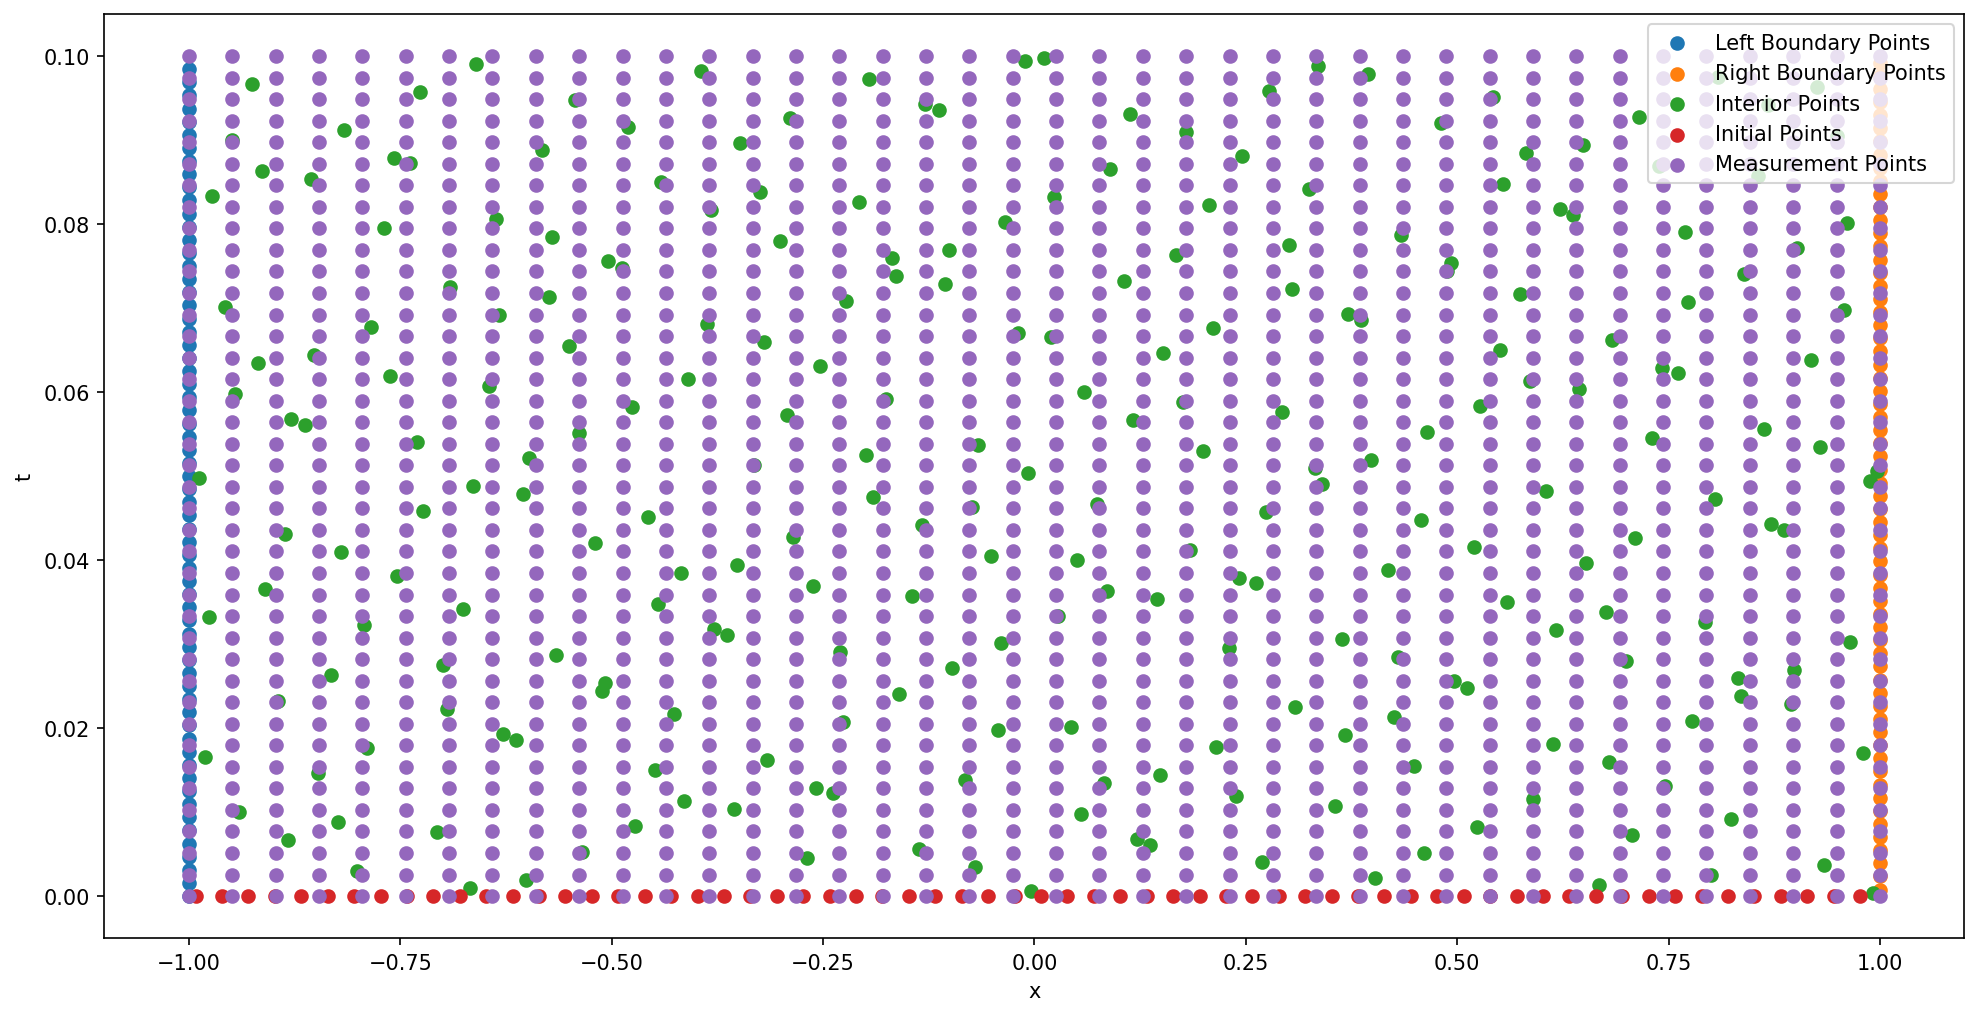

In [4]:
pde.plot_training_points()

In [5]:
optimizer = pde.optimizer_LBFGS(config)
start = time.time()
history = pde.enhanced_fit(
    num_epochs=config.num_epochs,
    optimizer=optimizer,
    config=config,
    verbose=True
)
end = time.time()
print('Time taken: ', end - start)


Epoch [1/150]
Total Loss: -0.044534 | Boundary Loss: -1.276131 | PDE Loss: -0.476487 | Coefficient Loss: -1.638580 | LR: 8.000000e-01

Epoch [16/150]
Total Loss: -4.042523 | Boundary Loss: -5.322815 | PDE Loss: -4.365506 | Coefficient Loss: -5.483327 | LR: 8.000000e-01

Epoch [31/150]
Total Loss: -4.978826 | Boundary Loss: -6.999870 | PDE Loss: -5.022385 | Coefficient Loss: -7.326389 | LR: 8.000000e-01

Epoch [46/150]
Total Loss: -5.478587 | Boundary Loss: -7.113533 | PDE Loss: -5.593117 | Coefficient Loss: -7.334558 | LR: 8.000000e-01

Epoch [61/150]
Total Loss: -5.762030 | Boundary Loss: -7.265432 | PDE Loss: -5.925564 | Coefficient Loss: -7.714832 | LR: 8.000000e-01

Epoch [76/150]
Total Loss: -5.917771 | Boundary Loss: -7.390318 | PDE Loss: -6.096168 | Coefficient Loss: -7.944891 | LR: 8.000000e-01

Epoch [91/150]
Total Loss: -5.917771 | Boundary Loss: -7.390318 | PDE Loss: -6.096168 | Coefficient Loss: -7.944891 | LR: 8.000000e-01

Early stopping triggered at epoch 94

Training c

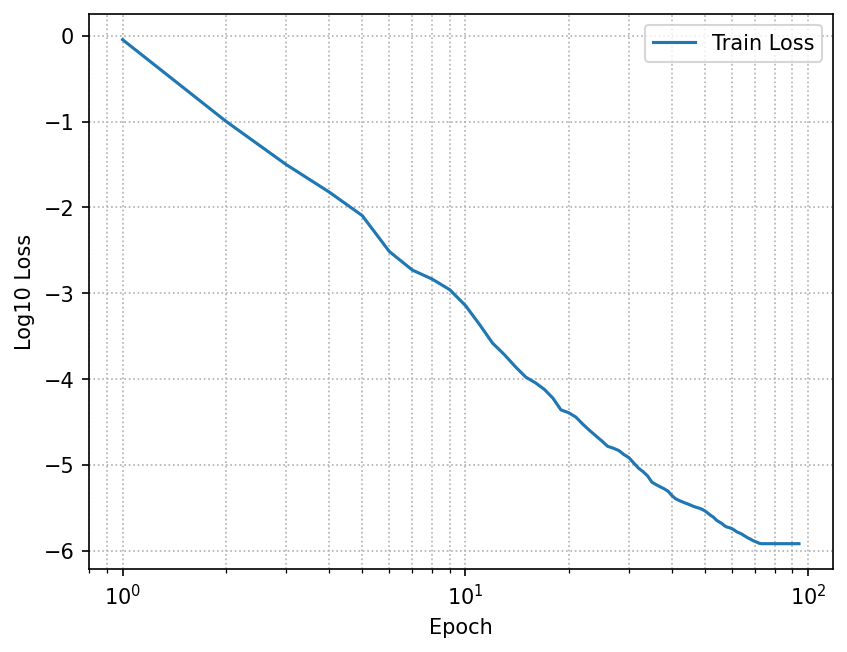

In [6]:
pde.plot_train_loss(history)

pde loss:
L2 Relative Error Norm: 2.251312e-04


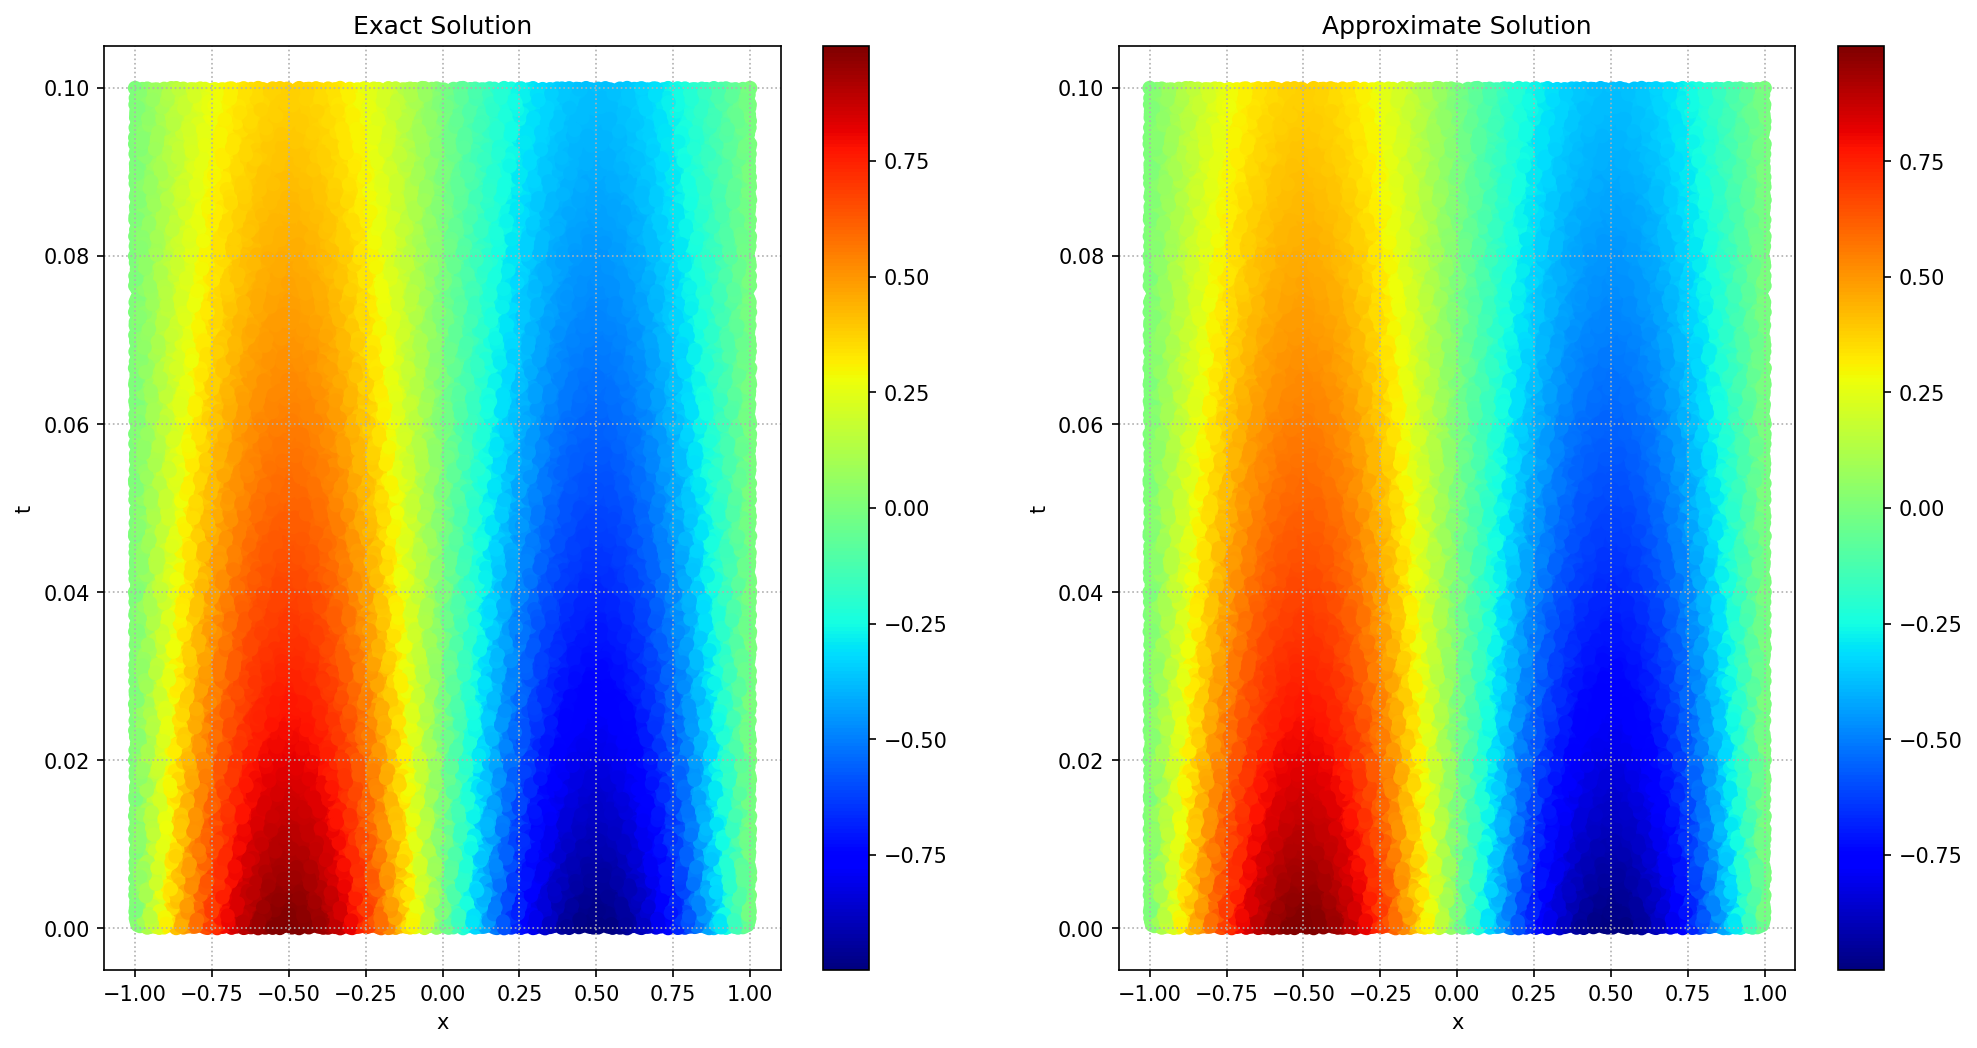

In [7]:
pde.plotting_solution(50000, function='pde')

coefficient loss:
L2 Relative Error Norm: 1.116881e-02


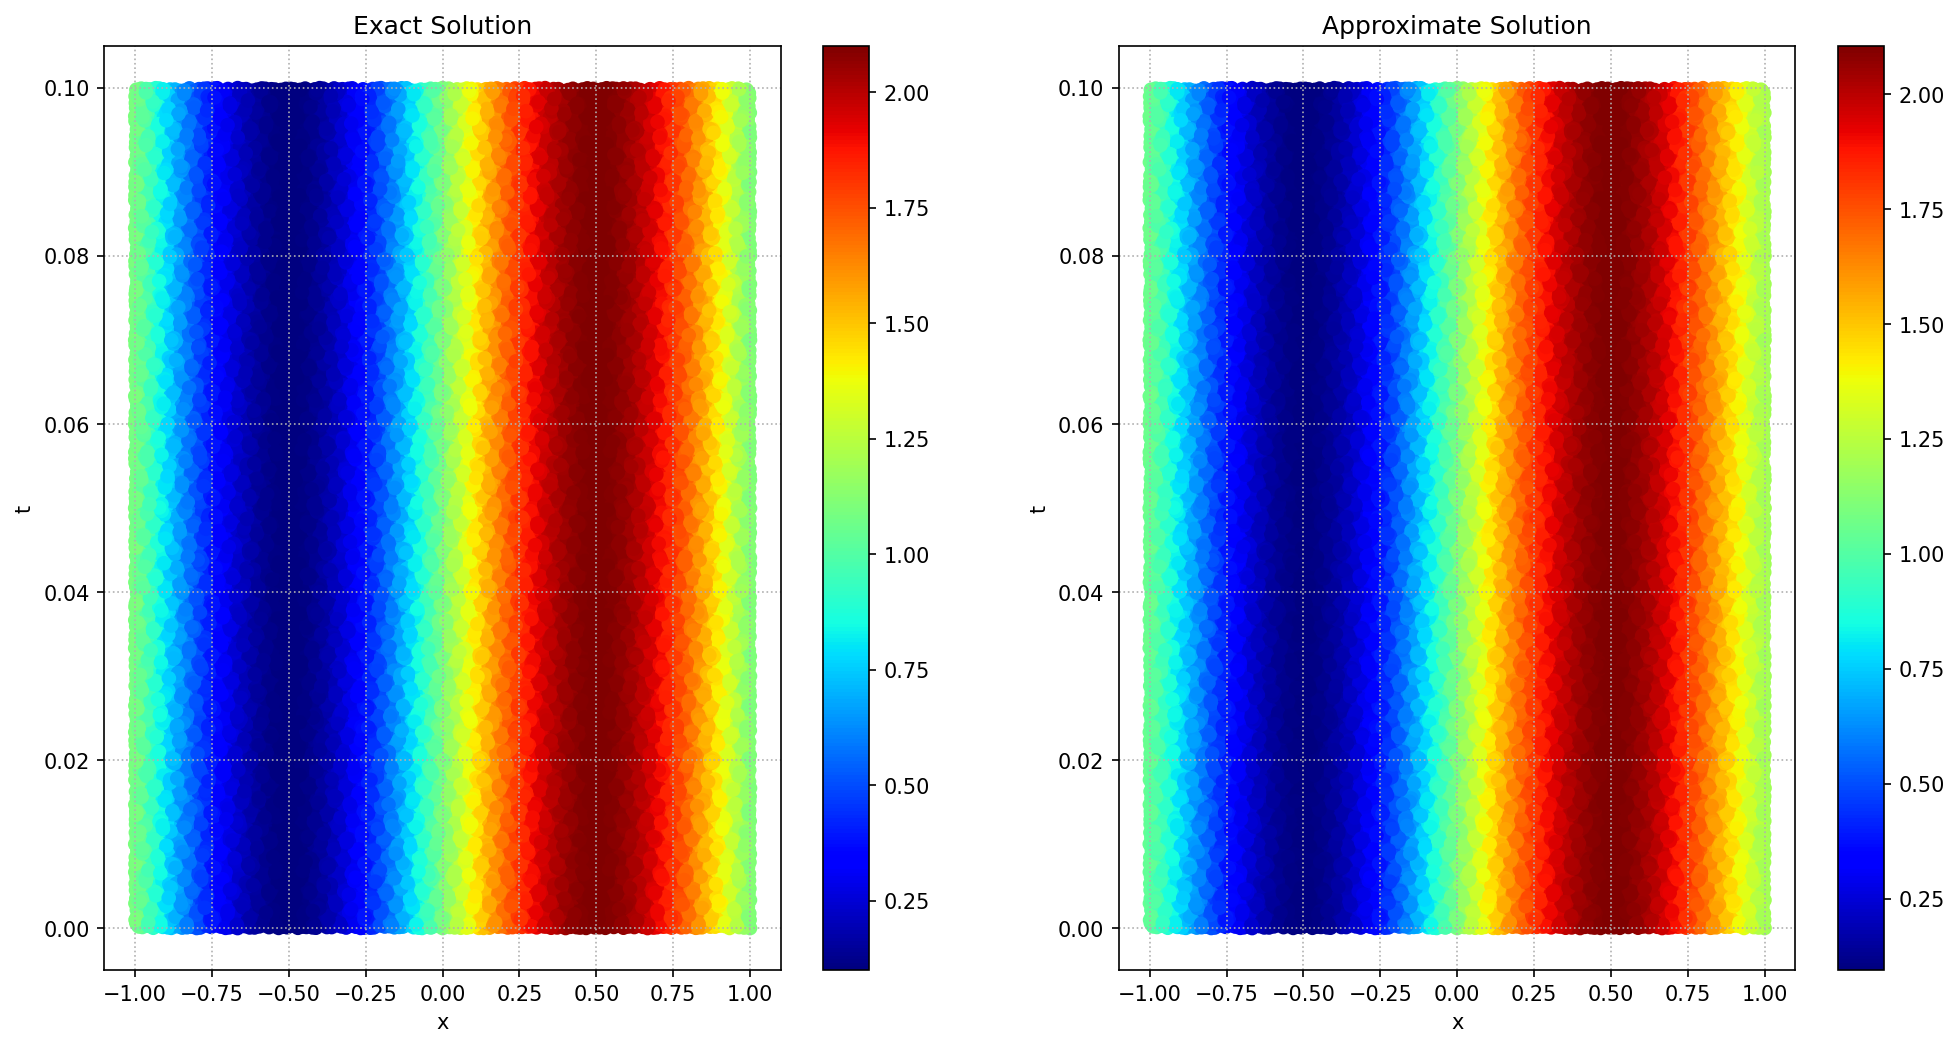

In [8]:
pde.plotting_solution(50000, function='coefficient')